# Dask delay

Not everything reduces to what is inside numpy (dask array API).

Dask delayed allows you to:
  1. Do custom computations with regular python code
  2. Scale them up to heterogeneous clusters

Let's setup the same infrastructure as before

In [5]:
# Local client
from dask import delayed
from dask.distributed import Client
n_workers = 30


def scale_to_sge(n_workers):
    queue="q_1day"
    queue_resource_spec="q_1day=TRUE"
    memory="4GB"
    sge_log= "./logs"
    from dask_jobqueue import SGECluster
    cluster = SGECluster(queue=queue, memory=memory, cores=1, processes=1,
              log_directory=sge_log,
              local_directory=sge_log,
              resource_spec=queue_resource_spec
              )
    cluster.scale_up(n_workers)
    return Client(cluster)  # start local workers as threads

# Local client
client = Client(n_workers=n_workers)

# SGE client
#client = scale_to_sge(n_workers)



/idiap/user/tpereira/conda/envs/tam-dask/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34437 instead
  warnings.warn(


# Training an GMM-UBM distributed using Dask

In the example below dask delayed is used to build a simple pipeline to train GMM-UBM with speaker data.
The pipeline is pretty simple and can be split in the parts.

## Feature extraction.

For each audio file the following steps are piped using dask delayed:

  1. File opening (using scipy)
  2. Training and detection segments that contains audio (bob.bio.spear.preprocessor.Energy_2Gauss)
  3. Extraction of MFCC features (bob.bio.spear.extractor.Cepstral)
 
## GMM training

Once we have the MFCCs for all audio file, we can run the EM algorithm to train the GMM.
In this example a GMM is initialized from some previous GMM (just for the sake of the example).
Furthermore, only the GMM means are updated during the mstep.

For GMM training, for each EM iteration, the following steps are piped using dask delays:

  1. E-step. For each block of MFCSS compute the posterior probabilities. Those posteriors are accumulated using two statistics. The first one, called zeroth order, is the simple summation of the posteriors. The second one, called first order, is the dot product between zeroth order and the input MFCCs data.
  2. Accumulation. The statistics from the previous step is accumulated using the (everything is summed)
  3. M-step. The recomputation of the means.
  

In [6]:
%%time

# fetching the data
import glob
import os

##### ADD YOUR PATH HERE. 
##### I CAN'T SHARE ONLINE A PATH FROM OUR SHARED FILE SYSTEM ##################
#PATH_TO_VOX_FORGE = ""
#paths = glob.glob(os.path.join(PATH_TO_VOX_FORGE, "16kHz_16bit/*/wav/*.wav"))
####################


import scipy
import numpy as np

em_iterations = 5
n_clusters = 5

def get_random_features(mean):
    """
    Emulates a feature extraction
    """
    return np.random.normal(loc=mean, scale=0.3, size=(200,3) )

def process(X): 
    return X+np.random.uniform(size=X.shape)


# GMM INITIALIZATION
from gmm_steps import e_step, m_step, acc_stats

# Initialization of the champions
# THE GMM has 2 gaussians
weights = np.array([0.5, 0.5])
variances = np.array([[0.1, 0.1, 0.1],[0.5, 0.5, 0.9]])
means = np.array([[0.1, 0.1, 0.1],[0.5, 0.5, 0.9]])
#####




# First part of the graph.
# emulating some reading data
all_samples = []
for i in range(n_clusters):
    
    data = delayed(get_random_features)(i)
    data = delayed(process)(data)
        
    all_samples.append(data)
    
# Second part of the graph
# EM
for i in range(em_iterations):
    gmm_stats = []
    for samples in all_samples:                    
        gmm_stats.append(delayed(e_step)(samples, weights, means, variances))
    
    acc_gmm_stats = delayed(acc_stats)(gmm_stats)
    means = delayed(m_step)(acc_gmm_stats)

means

CPU times: user 1.93 ms, sys: 4.7 ms, total: 6.63 ms
Wall time: 4.61 ms


Delayed('m_step-acd3265f-faa8-4e10-9e81-655ab490a856')

# Now that we have the graph. We execute it

Also, try to check what is in http://localhost:8787

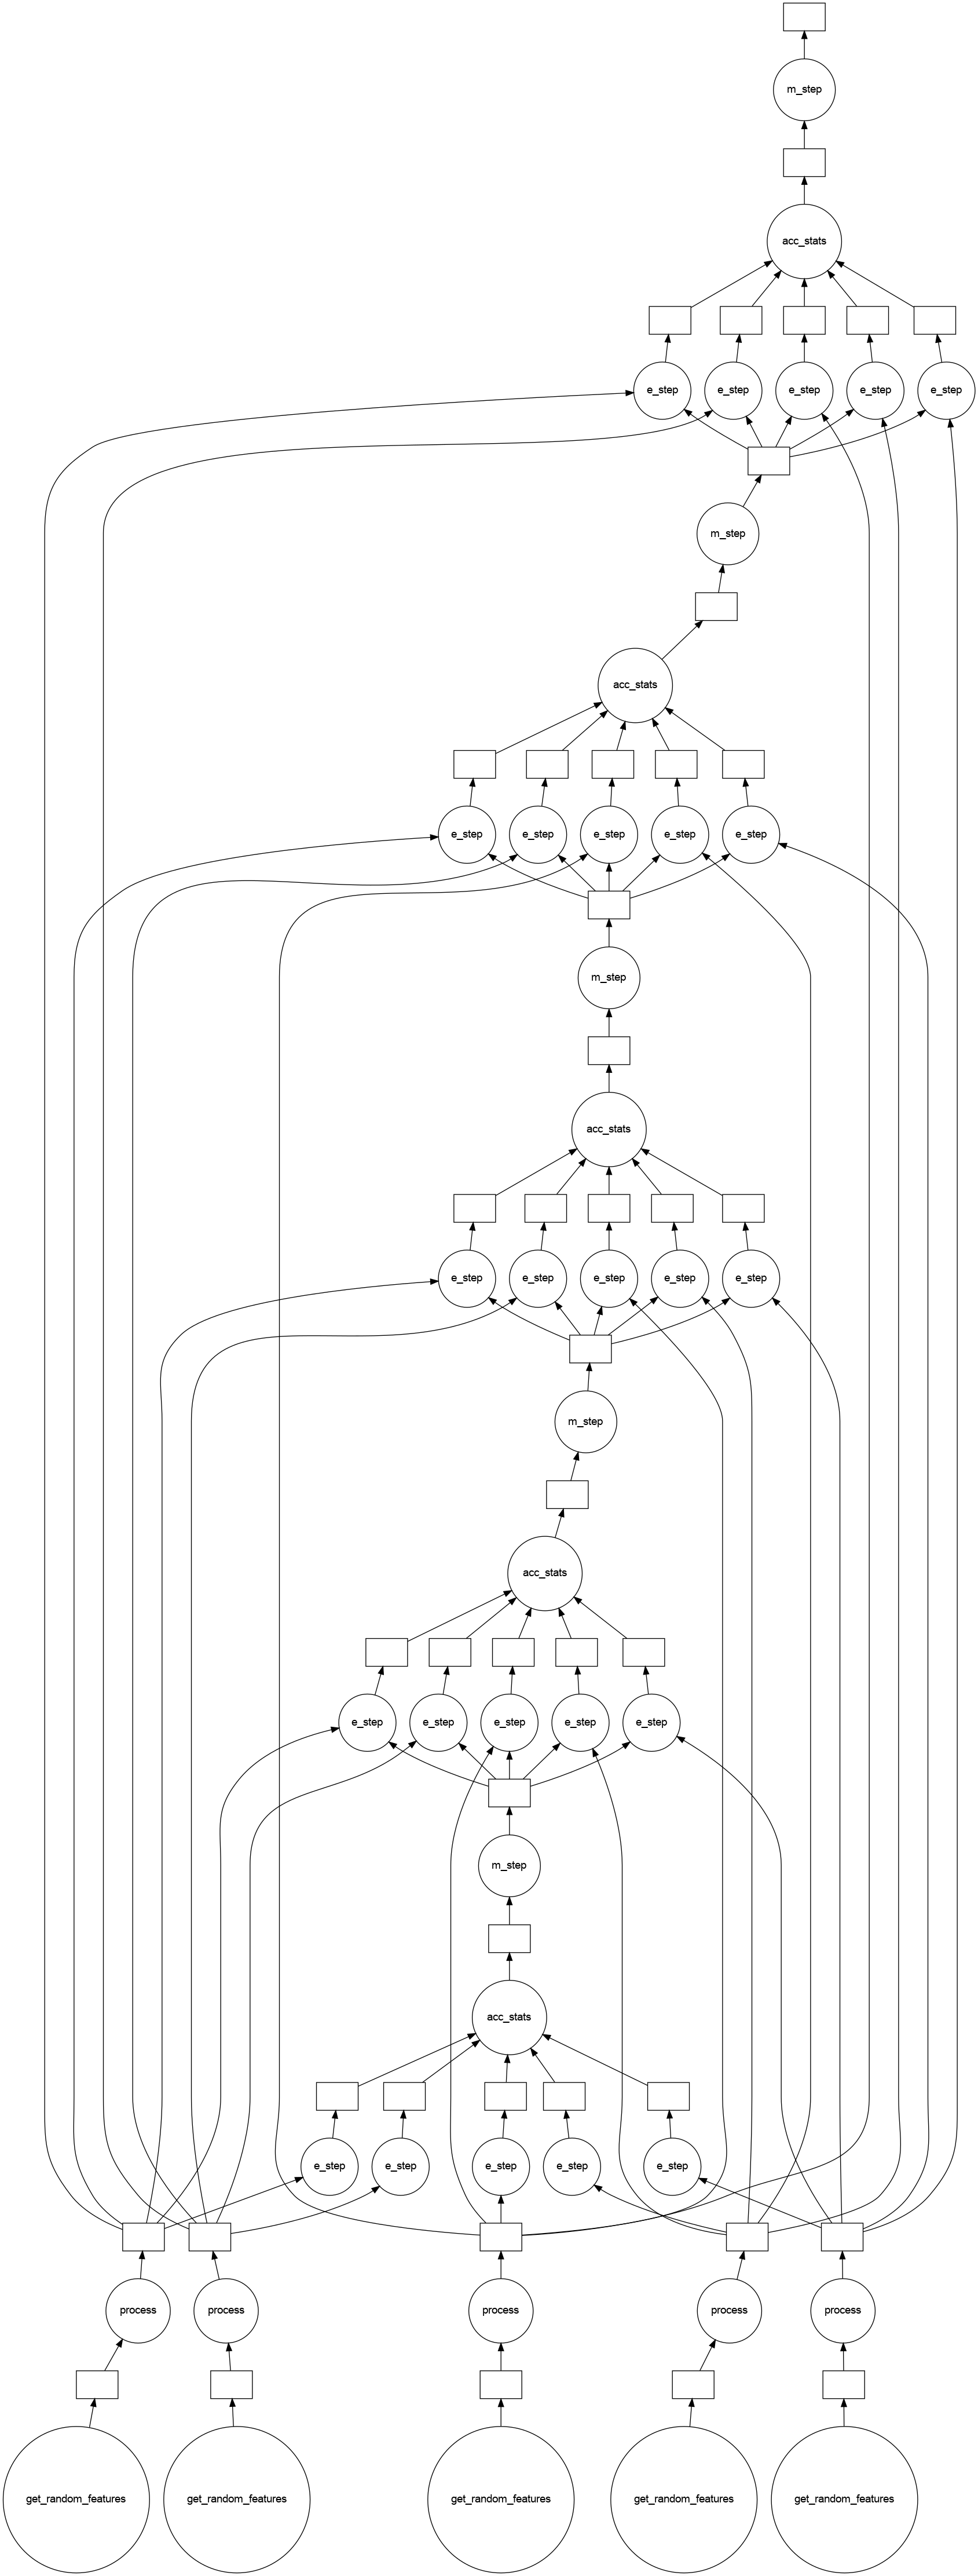

In [10]:
means.visualize()

In [9]:
%%time

print("Means at step [0]")
print(means)
print("##############")
print("Means at step [n]")
print(means.compute(scheduler=client))

Means at step [0]
Delayed('m_step-acd3265f-faa8-4e10-9e81-655ab490a856')
##############
Means at step [n]
[[0.72107694 0.65572997 0.72754251]
 [3.18641121 3.15988943 3.18052244]]
CPU times: user 298 ms, sys: 93.7 ms, total: 391 ms
Wall time: 1.33 s


# Always shutdown your client

In [ ]:
client.shutdown()